In [1]:
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
import obspy
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from obspy.geodetics import locations2degrees, degrees2kilometers
from tqdm import tqdm

## Morton Catalog

In [2]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2012-10-01 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2012-10-31 23:59:59.999999+0000', tz='UTC')

events_morton_201210= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton_201210.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
630,2.0,2.012100e+13,2012.0,10.0,1.0,4.0,32.0,57.05,40.7190,-125.9525,...,34.0,0.46,2.6,29.2,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-01 04:32:57+00:00
631,2.0,2.012100e+13,2012.0,10.0,1.0,23.0,30.0,58.38,40.5787,-124.8887,...,11.8,0.34,6.9,5.8,NaN,NaN,NaN,Slab,NaN,2012-10-01 23:30:58+00:00
632,2.0,2.012100e+13,2012.0,10.0,2.0,4.0,25.0,46.37,40.5592,-125.2087,...,24.1,0.30,1.7,5.0,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-02 04:25:46+00:00
633,2.0,2.012100e+13,2012.0,10.0,2.0,5.0,16.0,28.35,40.5075,-124.5450,...,7.3,0.35,1.1,1.2,NaN,NaN,NaN,Slab,NaN,2012-10-02 05:16:28+00:00
634,2.0,2.012100e+13,2012.0,10.0,2.0,6.0,17.0,18.88,40.4213,-125.3963,...,31.2,0.46,1.4,34.8,316.59,43.54,-85.95,Seaward of Trench,NaN,2012-10-02 06:17:18+00:00


In [3]:
events_morton_201210.keys()

Index(['CI YEAR', 'TSTRING', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE',
       'SECOND', 'LAT', 'LON', 'DEPTH', 'Md', 'Num P&S with weights > 0.1',
       'max az gap', 'dist to nearest stn', 'tt RMS', 'ERH', 'ERZ', 'STRIKE',
       'DIP', 'RAKE', 'PLATE DESIGNATION', 'TEMPLATE EVENT?', 'datetime'],
      dtype='object')

In [4]:
len(events_morton_201210)

91

## Our Catalog

In [5]:
# Load all the pick assignments 
mycatalog = pd.read_csv('../data/all_pick_assignments_october.csv')
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
mycatalog=mycatalog.loc[(mycatalog['datetime'] > t1) & (mycatalog['datetime'] < t2) ]
mycatalog.head()

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2012-10-01 11:20:42.478249+00:00,-41.447175,-129.175148,0.390625,9,40.585822,-125.239573,0.390625,0,102879,0.167164,FS09B,P,1.349090e+09,2012-10-01 11:20:42.478249+00:00
1,1,0,2012-10-01 11:20:42.478249+00:00,-41.447175,-129.175148,0.390625,9,40.585822,-125.239573,0.390625,0,234293,-0.201824,FS09B,S,1.349090e+09,2012-10-01 11:20:42.478249+00:00
2,2,0,2012-10-01 11:20:42.478249+00:00,-41.447175,-129.175148,0.390625,9,40.585822,-125.239573,0.390625,0,201197,-0.257888,FS13B,S,1.349090e+09,2012-10-01 11:20:42.478249+00:00
3,3,0,2012-10-01 11:20:42.478249+00:00,-41.447175,-129.175148,0.390625,9,40.585822,-125.239573,0.390625,0,10240,0.576825,FS16B,P,1.349090e+09,2012-10-01 11:20:42.478249+00:00
4,4,0,2012-10-01 11:20:42.478249+00:00,-41.447175,-129.175148,0.390625,9,40.585822,-125.239573,0.390625,0,154758,-0.428595,FS16B,S,1.349090e+09,2012-10-01 11:20:42.478249+00:00


In [6]:
matched_events_mycatalog= []
matched_times_morton = []
# matched_time_mycatalog = []
# matched_time_morton = []
unmatched_times_morton = []
unmatched_events_mycatalog = []
time_threshold = 2

lat_morton=[]
lon_morton=[]

for i in range(len(events_morton_201210)):
    t1 = events_morton_201210.iloc[i]['datetime']
    matched_df = mycatalog.loc[(mycatalog['datetime'] > t1 - pd.Timedelta(time_threshold,'minutes')) & 
                               (mycatalog['datetime'] < t1 +pd.Timedelta(time_threshold,'minutes')) ]
    
    unmatched_df = mycatalog.loc[~((mycatalog['datetime'] > t1 - pd.Timedelta(time_threshold,'minutes')) & 
                               (mycatalog['datetime'] < t1 +pd.Timedelta(time_threshold,'minutes'))) ]
    matched_events_mycatalog.append(matched_df)
    unmatched_events_mycatalog.append(unmatched_df)
    
    if len(matched_df) > 0:
        matched_times_morton.append(t1)
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        
        if len(matched_df['datetime'].unique()) > 1:
            matched_times_morton.append(t1)
            lat_morton.append(events_morton_201210.iloc[i]['LAT'])
            lon_morton.append(events_morton_201210.iloc[i]['LON'])
            
        else: pass
  
    else: 
        unmatched_times_morton.append(t1)
        

    
    print(i,len(matched_events_mycatalog),len(matched_df), len(matched_df['time'].unique()), events_morton_201210.iloc[i]['Md'])
    

0 1 0 0 3.68
1 2 11 1 2.37
2 3 16 1 2.94
3 4 14 1 2.8
4 5 12 1 3.02
5 6 18 1 3.03
6 7 0 0 1.67
7 8 16 1 3.26
8 9 0 0 1.16
9 10 13 1 2.78
10 11 13 1 3.2
11 12 0 0 2.26
12 13 0 0 1.77
13 14 0 0 2.55
14 15 0 0 1.72
15 16 10 1 2.19
16 17 11 1 2.26
17 18 16 1 3.21
18 19 15 1 2.78
19 20 18 1 2.75
20 21 19 1 3.13
21 22 10 1 2.83
22 23 11 1 2.71
23 24 0 0 2.44
24 25 7 1 2.65
25 26 11 1 2.43
26 27 16 1 3.14
27 28 12 1 2.95
28 29 27 2 3.04
29 30 0 0 2.5
30 31 17 1 3.0
31 32 0 0 1.61
32 33 0 0 1.9
33 34 16 1 2.5
34 35 0 0 2.45
35 36 19 2 2.51
36 37 9 1 2.97
37 38 11 1 2.6
38 39 0 0 2.59
39 40 8 1 2.55
40 41 10 1 2.65
41 42 11 1 2.43
42 43 11 1 2.78
43 44 0 0 1.94
44 45 17 1 2.57
45 46 9 1 2.74
46 47 13 1 2.57
47 48 0 0 2.09
48 49 13 1 2.76
49 50 26 1 3.33
50 51 0 0 1.5
51 52 10 1 2.44
52 53 7 1 2.91
53 54 7 1 2.35
54 55 12 1 2.91
55 56 10 1 2.45
56 57 17 1 2.9
57 58 14 1 2.96
58 59 7 1 4.26
59 60 8 1 4.06
60 61 11 1 2.55
61 62 14 1 2.99
62 63 12 1 2.81
63 64 11 1 2.8
64 65 19 1 3.81
65 66 0 0 2.6

In [7]:
matched_events_mycatalog

[Empty DataFrame
 Columns: [Unnamed: 0, idx, time, x, y, z, picks, latitude, longitude, depth, event_idx, pick_idx, residual, station, phase, time_pick, datetime]
 Index: [],
     Unnamed: 0  idx                              time         x          y  \
 48          48    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 49          49    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 50          50    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 51          51    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 52          52    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 53          53    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 54          54    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 55          55    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 56          56    5  2012-10-01 23:30:57.221978+00:00 -2.918815 -125.36433   
 57          57    5  2012-10-01 23

In [16]:
# Concatenate the list of dataframes
matched_events_mycatalog = pd.concat(matched_events_mycatalog)
# Drop duplicates by datetime
matched_events_mycatalog = matched_events_mycatalog.drop_duplicates(subset=['datetime'])
# Extract the datetimes 
matched_times_mycatalog = matched_events_mycatalog['datetime']
# Concatenate the list of unmatched dataframes
unmatched_times_mycatalog = pd.concat(unmatched_events_mycatalog)

# Define the latitudes and longitudes for my catalog
lat_mycatalog = matched_events_mycatalog['latitude']
lon_mycatalog = matched_events_mycatalog['longitude']

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:
lat_mycatalog = matched_events_mycatalog['latitude']

In [ ]:
len(unmatched_events_morton)

In [ ]:
len(unmatched_events_mycatalog)

In [ ]:
lat_mycatalog

In [ ]:
len(lon_mycatalog)

In [ ]:
['datetime'].iloc[0:50]

In [ ]:
unmatched_events_mycatalog['datetime'].unique()

In [ ]:
list_events['datetime'].iloc[0:50]

Text(0.5, 1.0, 'Scatter Plot: Origin Times of Matched Events')

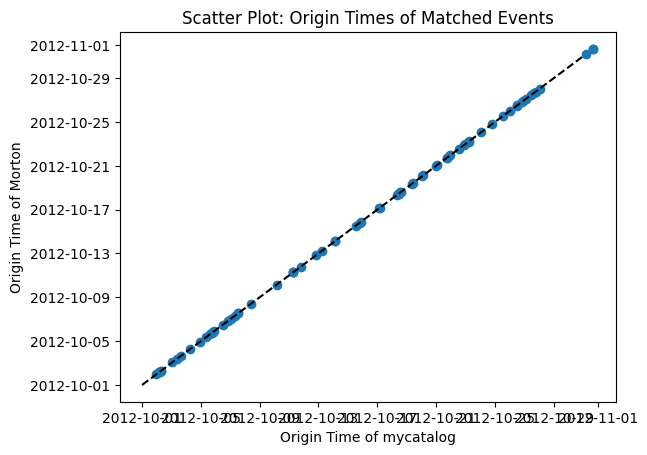

In [10]:
# Make lists for plotting the 1:1 line
x = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton))
y = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog,matched_times_morton)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

Text(0.5, 1.0, 'Scatter Plot: Latitudes of mycatalog vs.Latitudes of Morton')

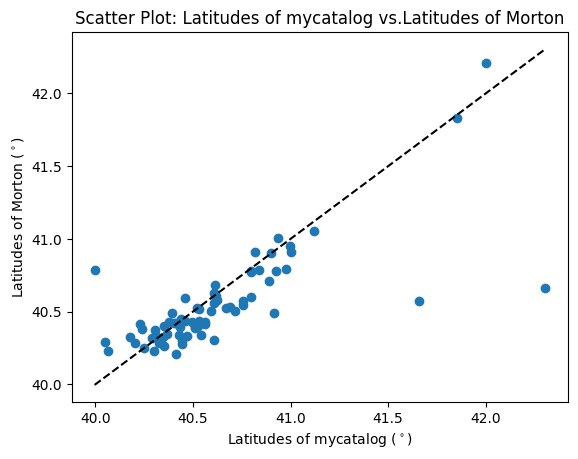

In [11]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog)
lat_max = max(lat_mycatalog)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog,lat_morton)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of mycatalog ($^\circ$)')
plt.ylabel('Latitudes of Morton ($^\circ$)')
plt.title('Scatter Plot: Latitudes of mycatalog vs.Latitudes of Morton')

Text(0.5, 1.0, 'Scatter Plot: Longitudes of mycatalog vs.Longitudes of Morton')

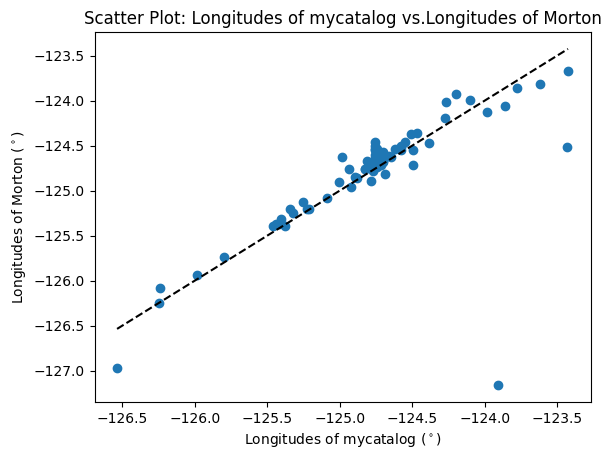

In [12]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog)
lon_max = max(lon_mycatalog)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog,lon_morton)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of mycatalog ($^\circ$)')
plt.ylabel('Longitudes of Morton ($^\circ$)')
plt.title('Scatter Plot: Longitudes of mycatalog vs.Longitudes of Morton')

## Histograms
Make histograms of mycatalog vs. Morton's catalog

### Histogram: All of our catalog (767 events)

In [13]:
events_october = pd.read_csv('../data/events_october.csv')

Text(0.5, 1.0, 'Histogram of Picks vs. the Number of Events')

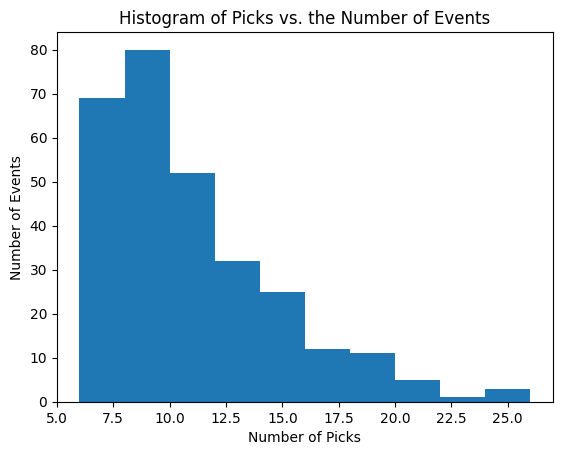

In [14]:
# Plot the histogram of the number of picks for all events in events_october.csv
plt.figure()
plt.hist(events_october['picks'])
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Picks vs. the Number of Events')

### Histogram: Those matched with Morton (73 events)

Text(0.5, 1.0, 'Histogram of Matched Events: Picks vs. the Number of Events')

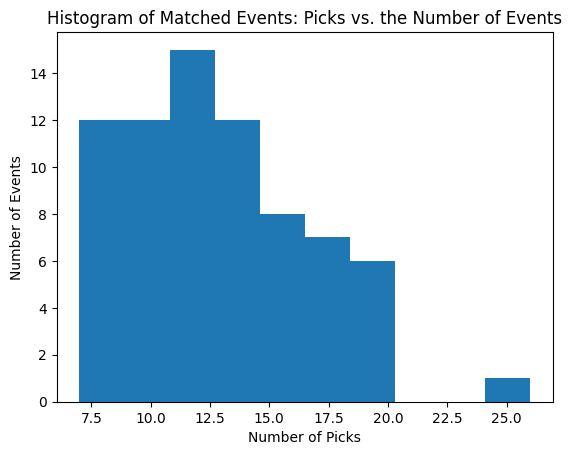

In [15]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
plt.hist(matched_events_mycatalog['picks'])
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events: Picks vs. the Number of Events')

### Plot the waveforms of one of the matched events 

In [ ]:
client = WaveformClient()
client2 = Client("IRIS")

In [ ]:
# Get the list of stations
station_list = ['FS09B',
 'FS13B',
 'FS16B',
 'FS17B',
 'FS20B',
 'G10B',
 'G17B',
 'G19B',
 'G25B',
 'G26B',
 'G27B',
 'J09B',
 'J25B',
 'J33B',
 'M09B',
 'M12B',
 'M14B']

In [ ]:
mycatalog[mycatalog['idx'] == 9]

In [ ]:
mycatalog['station'].unique()

In [ ]:
distances

In [ ]:
distances.keys()

In [ ]:
idx = 0
otime = UTCDateTime(mycatalog['datetime'].unique()[idx])
distances = {}
for i, sta in enumerate(station_list):
    sta_inv = client2.get_stations(network = "7D", station = sta, channel = "?H?", 
                     starttime = otime - 1e4, endtime = otime + 1e4)[0][0]
    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = mycatalog['latitude'].unique()[idx]
    olon = mycatalog['longitude'].unique()[idx]

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances[sta] = dist
distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
# print(distances.keys())
print(otime)
plt.figure(figsize=(15,10), dpi=150)
for i, sta in enumerate(distances.keys()):
    st = client.get_waveforms(network="7D", station=sta, channel="?H?", year=2012, month=10, day=14)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 60)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = np.arange(0,len(trim_st))
        offsets2 = np.arange(0,len(station_list)* (len(trim_st)),len(trim_st))

        for ii in range(len(trim_st)):
            plt.plot(trim_st[ii].times(type='utcdatetime'), trim_st[ii].data+offsets1[ii]*0.5+offsets2[i], 
                     color = 'gray', alpha=0.7, lw=0.5)    
        time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
                     if x['station'] == sta]
        if len(time_pick) > 0:
            for p in time_pick:
                if p[1] == 'P':
                    plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                     offsets1[ii]*0.5+offsets2[i]+1, color='r')
                else:
                    plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                     offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 


In [ ]:
st = client.get_waveforms(network="7D", station='FS16B', channel="?H?", year=2012, month=10, day=14)
st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
st.filter(type='bandpass',freqmin=4,freqmax=15)

trim_st = st.copy().trim(starttime = otime - 30, 
            endtime = otime + 60)
trim_st
st

In [ ]:
otime